### The mean value of TriggerOffset

In this little document I want to understand why the TriggerOffset can have a non vanishing mean value. But let's start at the beginning. We will want some plots, so lets import some plotting libraries and get over with it.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(0)

For this study I want to look at one DRS4 channel only, i.e. one pixel only, in FACT lingo. Also let's assume a DRS4 channel consists of **100 capacitors** instead of the 1024 it really consists of. 

In [2]:
N = 100

We *know* each of these storage cells behaves like a little amplifier, and a real amplifier never has unity gain and zero offset. So at least in zeroth order approx, each cell has an offset $o_c$ with the index $c$ denoting the cell number within a range of [0..99]. 

Let's assume we know this offset. And let's give it a pseudo-noisy but still remarkable shape. 

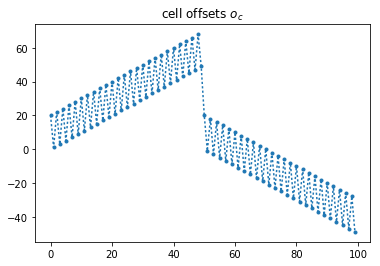

In [3]:
o = np.zeros(N, dtype='i2')
o[:N//2] += np.arange(N//2)
o[N//2:] += -np.arange(N//2)
o[::2] += 20
plt.plot(o, '.:')
plt.title('cell offsets $o_c$')
None

### Measurement process

In order to measure a signal (in this case the zero-signal) we create a function describing this measurement process as:

 * adding white noise
 * adding a hypothetical "trigger offset"
 * adding the cell offsets accoring to the stop cell $s_m$

In [4]:
def measured_signal(sm, noise=10):
    # we measure 'zero'
    signal = np.zeros(o.size, dtype='i2')
    # ... add some noise
    signal += np.random.normal(0, noise, size=o.size).astype('i2')

    # ... add a hypthetical trigger offset
    signal += trigger_offset()
    
    # ... and the offset of the storage cells according to the stop cell.
    signal += np.roll(o, sm) 
    
    return signal 

### What do we mean by "trigger offset"?

Let's assume there is not only the offset caused by each storage cell $o_c$, but in addition there is "something" overlayed on each measurement. A time dependent signal with respect to the start of the measurement. This "start of the measurement" is often called "trigger time" and since the signal is added to the real signal to be measured we call it "offset" - "trigger offset".

In this case, let's use an exponential function as out hypothetical trigger offset. We assume this time dependent offset exists somehow at the beginning of the measurement and then slowly vanishes ... 

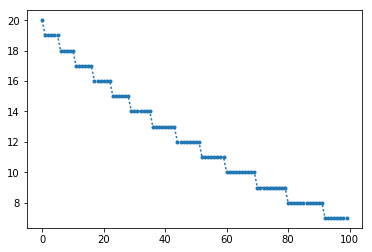

In [5]:
def trigger_offset(A=20):
    return (A * np.exp(-np.arange(o.size) / o.size)).astype('i2')

plt.plot(trigger_offset(), '.:')

### Example measurements

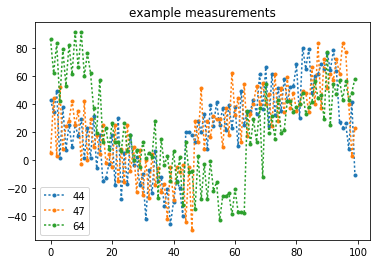

In [6]:
M = 3
s = np.random.randint(N, size=M)
for sm in s:
    plt.plot(measured_signal(sm), '.:', label=str(sm))
plt.legend()
plt.title('example measurements')
None

One can clearly see the noisy structure of $o_c$ in the data, even though it is noisy and rolled around due to the different $s_m$. Now in order to measure each individual $o_c$, lets repeat this measuement M=1000 times, unroll the data, so that by averaging over all measurements we retain our best guess for the $o_c$.

### Measurement of the $o_c$
Now let's measure $o_c$. 

We read out our test DRS4 channel $M$ times with the measurement index $m$ having a range of [0..M-1]. Readout starts and a random position $s_m$. We always readout the entire channel of 100 samples. Of course each measurement has some random noise added to it, so 3 example measurements might look like this.

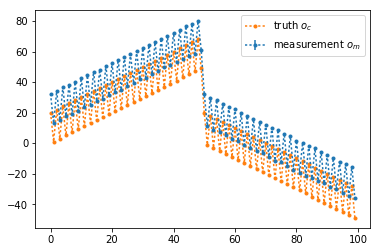

In [7]:
M = 1000
o_m = []
s = np.random.randint(N, size=M)
for sm in s:
    signal = measured_signal(sm)
    derolled_signal = np.roll(signal, -sm)
    o_m.append(derolled_signal)
o_m = np.array(o_m)
plt.errorbar(
    x=np.arange(N),
    y=o_m.mean(axis=0),
    yerr=o_m.std(axis=0) / np.sqrt(M),
    fmt='.:',
    label='measurement $o_m$'
)
plt.plot(o, '.:', label='truth $o_c$')
plt.legend()

None

Now what's this? There is clearly something like a constant offset between the true $o_c$ and the measured $o_m$. This is of course related to our hypothetical trigger offset. Let's take a closer look.

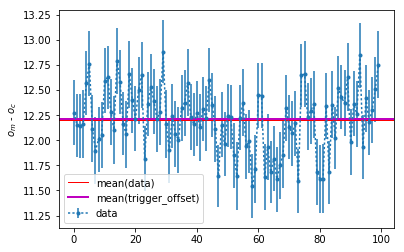

In [8]:
plt.errorbar(
    x=np.arange(N),
    y=o_m.mean(axis=0) - o,
    yerr=o_m.std(axis=0) / np.sqrt(M),
    fmt='.:',
    label='data'
)
plt.ylabel("$o_m$ - $o_c$")
plt.axhline((o_m.mean(axis=0) - o).mean(), color='r', lw=1, label='mean(data)')
plt.axhline(trigger_offset().mean(), color='m', lw=2, label='mean(trigger_offset)')
plt.legend()
None

So clearly $o_{c,m}$ is not equal to $o_c$, instead:

$o_{c,m} = o_c + triggeroffset.mean$

However, the measurement of the $o_{c,m}$ does not tell us, whether there is a trigger offset hidden within the `measured_signal` or not. But what when we apply this calibration to another independent set of measurements.

### Application of the $o_{c,m}$

3 Example "events".

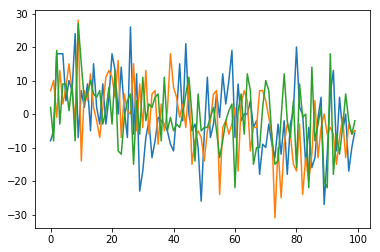

In [9]:
omm = o_m.mean(axis=0).astype('i2')
M = 3
s = np.random.randint(N, size=M)
for sm in s:
    signal = measured_signal(sm)
    signal -= np.roll(omm, sm)
    plt.plot(signal)
None

We see, the example events do not show the structure of the $o_c$ anymore. So the calibration looks successful. However we can already see, there might be something like a trigger_offset going on. However the overall noise of each event hides it. 

So let's use 1000 events.

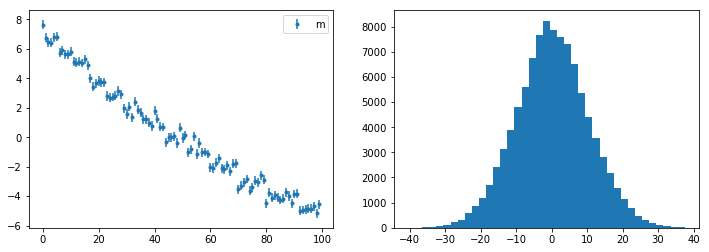

In [10]:
omm = o_m.mean(axis=0).astype('i2')
M = 1000
m = []
s = np.random.randint(N, size=M)
for sm in s:
    signal = measured_signal(sm)
    signal -= np.roll(omm, sm)
    m.append(signal)
m = np.array(m)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].errorbar(
    x=np.arange(N),
    y=m.mean(axis=0),
    yerr=m.std(axis=0) / np.sqrt(M),
    fmt='.',
    label='m'
)

axes[0].legend()

axes[1].hist(m.flat, bins=np.arange(-40, 40, 2)-0.5)

None

We see immediately that we could now fit a model at these `m` values and learn something about the trigger offset. However the mean of the calibrated values is very well compatible with zero.

Now how can it be, that the mean value of FACTs TriggerOffset is not compatible with zero?

Well we should keep in mind that we only measure the trigger offset on one third of the entire 1024 cells, i.e. on 300 cells, so if we only look at the the first 33 cells of our calibrated test data `m`:

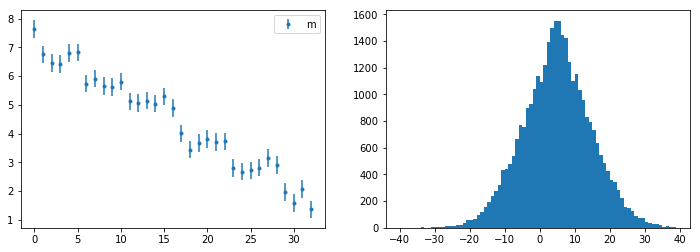

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].errorbar(
    x=np.arange(33),
    y=m[:,:33].mean(axis=0),
    yerr=m[:,:33].std(axis=0) / np.sqrt(M),
    fmt='.',
    label='m'
)

axes[0].legend()

axes[1].hist(m[:,:33].flat, bins=np.arange(-40, 40))

None

We clearly see, the mean of the measured trigger offset does of course not vanish.

In FACT we measure mean values of about 8mV and slopes of about 4uV/slice within the first 300 slices. 